In [1]:
# Cell 1 — imports & PYTHONPATH
import sys
from pathlib import Path
import random

import torch
import torch.nn.functional as F
from torch import optim
import numpy as np

# project setup
PROJECT_ROOT = Path('..').resolve()
sys.path.append(str(PROJECT_ROOT / 'src'))

from utils      import load_image, load_mask, compute_vector_field
from engine     import AntEnv
from model      import AntModel


In [2]:
# Cell 2 — helper to pack obs into tensors
def pack_inputs(patch_np, memory, device):
    pt = torch.from_numpy(patch_np.astype(np.float32)/255)\
              .permute(2,0,1).unsqueeze(0).to(device)
    mem_t = []
    for p_np, a_np in memory:
        p_t = torch.from_numpy(p_np.astype(np.float32)/255)\
                  .permute(2,0,1).to(device)
        a_t = torch.from_numpy(a_np.astype(np.float32)).to(device)
        mem_t.append((p_t, a_t))
    return pt, mem_t


In [ ]:
# Cell 3 — Agent wrapper
class Agent:
    def __init__(self, device, img, mask, vf):
        self.env = AntEnv(img, mask, vf, kernel_size=(16,16), memory_len=50, max_steps=200)
        self.model = AntModel(in_channels=3, patch_size=(16,16), emb_dim=128, n_actions=8, n_heads=4).to(device)
        self.opt   = optim.Adam(self.model.parameters(), lr=1e-3)
        self.energy = 50
        # initialize obs + memory
        self.obs_patch, self.mem = self.env.reset()

    def step_and_learn(self, device):
        # forward
        pt, mem_t = pack_inputs(self.obs_patch, self.mem, device)
        logits    = self.model(pt, mem_t)
        dist      = torch.distributions.Categorical(logits=logits)
        action    = dist.sample()
        logp      = dist.log_prob(action)

        # # env step
        # (obs2, mem2), _, done, _ = self.env.step(int(action.item()))

        # # energy update
        # delta = 1 if self.env.is_in_cell() else -1
        # self.energy += delta

        # # one‐step policy‐gradient update
        # loss = - logp * delta

        # env step: get the cosine‐based reward *and* whether we're in‐cell
        (obs2, mem2), cosine_r, done, _ = self.env.step(int(action.item()))
        in_cell = self.env.is_in_cell()

        # occupancy bonus: +1 in cell, -1 out of cell
        occ_r = 1 if in_cell else -1

        # combine them (you can weight occ_r if you like, e.g. w_occ * occ_r)
        r_total = cosine_r + occ_r

        # still update evolutionary energy by occupancy only
        self.energy += occ_r

        # policy‐gradient step uses the combined signal
        loss = - logp * r_total


        self.opt.zero_grad()
        loss.backward()
        self.opt.step()

        # store next obs for next step
        self.obs_patch, self.mem = obs2, mem2

        return done


In [4]:
# Cell 4 — load data & initialize 10 agents
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# use the same image/mask for all ants
img_path  = PROJECT_ROOT / 'data/Fold1_jpg/images/1.jpg'
mask_path = PROJECT_ROOT / 'data/Fold1_jpg/masks/1.jpg'
img  = load_image(str(img_path))
mask = load_mask(str(mask_path))
vf   = compute_vector_field(mask)

# spawn population
N = 10
agents = [Agent(device, img, mask, vf) for _ in range(N)]


In [5]:
# Cell 5 — evolutionary / energy loop with automatic best‐model saving

global_step = 0
LOG_INTERVAL = 10
best_energy = -float('inf')
best_agent = None

try:
    while True:
        global_step += 1

        # step & learn for each agent
        for i, ag in enumerate(agents):
            ag.step_and_learn(device)

            # track best so far
            if ag.energy > best_energy:
                best_energy = ag.energy
                best_agent = ag

            # respawn if dead
            if ag.energy <= 0:
                agents[i] = Agent(device, img, mask, vf)

            # stop early if someone masters
            if ag.energy >= 5000:
                print(f"🏆 Agent {i} reached {ag.energy} energy at step {global_step}!")
                raise SystemExit

        # periodic logging
        if global_step % LOG_INTERVAL == 0:
            energies = [int(a.energy) for a in agents]
            best_idx = energies.index(max(energies))
            last_positions = agents[best_idx].env.trajectory[-10:]
            print(f"[Step {global_step:05d}] Energies: {energies}")
            print(f"  ▶ Best Agent #{best_idx} last 10 positions: {last_positions}")

except KeyboardInterrupt:
    print(f"🔴 Training manually interrupted at step {global_step}.")

finally:
    import os
    os.makedirs('Agents', exist_ok=True)
    for idx, ag in enumerate(agents):
        path = f'Agents/agent_{idx}.pth'
        torch.save(ag.model.state_dict(), path)
    print(f"💾 Saved all {len(agents)} agent models into 'Agents/'")


[Step 00010] Energies: [40, 40, 40, 40, 40, 54, 40, 40, 40, 40]
  ▶ Best Agent #5 last 10 positions: [(169, 192), (174, 187), (179, 192), (184, 192), (189, 197), (184, 192), (189, 192), (194, 197), (199, 202), (194, 207)]
[Step 00020] Energies: [30, 30, 30, 30, 38, 50, 30, 30, 30, 30]
  ▶ Best Agent #5 last 10 positions: [(199, 212), (194, 207), (199, 207), (194, 202), (199, 202), (204, 207), (199, 202), (194, 197), (194, 192), (189, 187)]
[Step 00030] Energies: [20, 20, 20, 20, 38, 54, 20, 20, 20, 40]
  ▶ Best Agent #5 last 10 positions: [(184, 187), (189, 192), (184, 187), (179, 192), (179, 197), (184, 192), (179, 187), (174, 192), (169, 197), (174, 197)]
[Step 00040] Energies: [16, 10, 10, 10, 46, 44, 10, 10, 10, 34]
  ▶ Best Agent #4 last 10 positions: [(12, 200), (17, 200), (22, 200), (27, 200), (32, 200), (37, 200), (42, 200), (47, 200), (52, 200), (57, 200)]
[Step 00050] Energies: [6, 50, 50, 50, 36, 34, 14, 50, 50, 24]
  ▶ Best Agent #1 last 10 positions: [(40, 189)]
[Step 0006

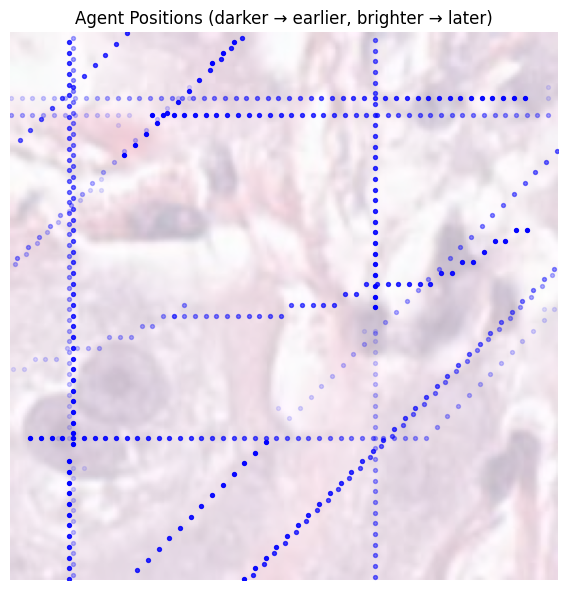

In [6]:
# Cell 7 — Scatter each ant’s positions with brightness increasing over time

import glob
import matplotlib.pyplot as plt
import numpy as np

model_paths = sorted(glob.glob('Agents/agent_*.pth'))

plt.figure(figsize=(6,6))
plt.imshow(img, alpha=0.3)
plt.axis('off')
plt.title('Agent Positions (darker → earlier, brighter → later)')

for mp in model_paths:
    # load model
    model = AntModel(in_channels=3, patch_size=(16,16),
                     emb_dim=128, n_actions=8, n_heads=4).to(device)
    model.load_state_dict(torch.load(mp, map_location=device))
    model.eval()

    # fresh torus‐wrapped env
    eval_env = AntEnv(img, mask, vf,
                      kernel_size=(16,16),
                      memory_len=100,
                      max_steps=500,
                      boundary='torus')
    obs_patch, mem = eval_env.reset()

    # rollout greedy for up to 500 steps
    for _ in range(50):
        pt, mem_t = pack_inputs(obs_patch, mem, device)
        with torch.no_grad():
            logits = model(pt, mem_t)
        action = int(logits.argmax(dim=-1).item())
        (obs_patch, mem), _, done, _ = eval_env.step(action)
        if done:
            break

    traj = np.array(eval_env.trajectory)  # shape (T,2)
    T = len(traj)
    xs, ys = traj[:,0], traj[:,1]

    # scatter with alpha increasing from 0.1 → 1.0
    for t, (x, y) in enumerate(zip(xs, ys)):
        alpha = 0.1 + 0.9 * (t / (T - 1))
        plt.scatter(x, y, s=8, color='blue', alpha=alpha)

plt.tight_layout()
plt.show()
